## Loading Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

## Training and Testing Utils

In [5]:
import time
from tqdm import tqdm

In [6]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cpu', model_name='model'):
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    
    valid_loss_history = []
    valid_accuracy_history = []
    
    best_iter = 0
    best_valid_loss = float('inf')
    best_valid_accuracy = 0.0
    best_model = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            predicted = outputs.argmax(dim=1)
            train_corrects += (predicted == labels).sum().item()
    
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        model.eval()
        
        valid_loss, valid_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = outputs.argmax(dim=1)
                valid_corrects += (predicted == labels).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_corrects / len(valid_loader.dataset)
        
        if valid_accuracy > best_valid_accuracy:
            best_iter = epoch + 1
            best_valid_loss = valid_loss
            best_valid_accuracy = valid_accuracy
            best_model = model.state_dict()
        
        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)
        
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')
    
    end_time = time.time()

    print(f'Total training time: {end_time - start_time:.2f} seconds.')
    
    torch.save(best_model, f'weights/{model_name}_best.pth')
    
    print(f'Best model at epoch {best_iter} with valid loss: {best_valid_loss:.4f}, valid accuracy: {best_valid_accuracy:.4f}')

    return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [7]:
def test_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    
    test_loss, test_corrects = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            predicted = outputs.argmax(dim=1)
            test_corrects += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_corrects / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%')
    
    return test_loss, test_accuracy

## Loading Models

In [8]:
from models import lnn, cnn
from matplotlib import pyplot as plt

#### Linear Neural Network

In [9]:
lnn_model = lnn.LNN(32 * 32 * 3, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  34526978


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='lnn_model')

Epoch 1/30: 100%|██████████| 313/313 [00:00<00:00, 384.14it/s]


Train Loss: 1.8207, Train Accuracy: 0.3446
Valid Loss: 1.6370, Valid Accuracy: 0.4078


Epoch 2/30: 100%|██████████| 313/313 [00:00<00:00, 399.64it/s]


Train Loss: 1.5601, Train Accuracy: 0.4448
Valid Loss: 1.5174, Valid Accuracy: 0.4607


Epoch 3/30: 100%|██████████| 313/313 [00:00<00:00, 395.32it/s]


Train Loss: 1.4395, Train Accuracy: 0.4876
Valid Loss: 1.4512, Valid Accuracy: 0.4834


Epoch 4/30: 100%|██████████| 313/313 [00:00<00:00, 393.99it/s]


Train Loss: 1.3459, Train Accuracy: 0.5228
Valid Loss: 1.4054, Valid Accuracy: 0.5058


Epoch 5/30: 100%|██████████| 313/313 [00:00<00:00, 404.71it/s]


Train Loss: 1.2636, Train Accuracy: 0.5526
Valid Loss: 1.3884, Valid Accuracy: 0.5093


Epoch 6/30: 100%|██████████| 313/313 [00:00<00:00, 417.86it/s]


Train Loss: 1.1948, Train Accuracy: 0.5757
Valid Loss: 1.3508, Valid Accuracy: 0.5281


Epoch 7/30: 100%|██████████| 313/313 [00:00<00:00, 396.16it/s]


Train Loss: 1.1232, Train Accuracy: 0.6020
Valid Loss: 1.3631, Valid Accuracy: 0.5268


Epoch 8/30: 100%|██████████| 313/313 [00:00<00:00, 386.67it/s]


Train Loss: 1.0585, Train Accuracy: 0.6259
Valid Loss: 1.3914, Valid Accuracy: 0.5217


Epoch 9/30: 100%|██████████| 313/313 [00:00<00:00, 403.15it/s]


Train Loss: 0.9928, Train Accuracy: 0.6506
Valid Loss: 1.3745, Valid Accuracy: 0.5337


Epoch 10/30: 100%|██████████| 313/313 [00:00<00:00, 376.62it/s]


Train Loss: 0.9275, Train Accuracy: 0.6713
Valid Loss: 1.3874, Valid Accuracy: 0.5313


Epoch 11/30: 100%|██████████| 313/313 [00:00<00:00, 386.46it/s]


Train Loss: 0.8624, Train Accuracy: 0.6947
Valid Loss: 1.4267, Valid Accuracy: 0.5247


Epoch 12/30: 100%|██████████| 313/313 [00:00<00:00, 424.73it/s]


Train Loss: 0.7981, Train Accuracy: 0.7176
Valid Loss: 1.4473, Valid Accuracy: 0.5265


Epoch 13/30: 100%|██████████| 313/313 [00:00<00:00, 331.32it/s]


Train Loss: 0.7349, Train Accuracy: 0.7384
Valid Loss: 1.5084, Valid Accuracy: 0.5325


Epoch 14/30: 100%|██████████| 313/313 [00:00<00:00, 354.12it/s]


Train Loss: 0.6733, Train Accuracy: 0.7609
Valid Loss: 1.5505, Valid Accuracy: 0.5340


Epoch 15/30: 100%|██████████| 313/313 [00:00<00:00, 320.04it/s]


Train Loss: 0.6092, Train Accuracy: 0.7831
Valid Loss: 1.6334, Valid Accuracy: 0.5262


Epoch 16/30: 100%|██████████| 313/313 [00:00<00:00, 417.08it/s]


Train Loss: 0.5488, Train Accuracy: 0.8048
Valid Loss: 1.7489, Valid Accuracy: 0.5243


Epoch 17/30: 100%|██████████| 313/313 [00:00<00:00, 417.22it/s]


Train Loss: 0.4994, Train Accuracy: 0.8252
Valid Loss: 1.7790, Valid Accuracy: 0.5279


Epoch 18/30: 100%|██████████| 313/313 [00:00<00:00, 408.25it/s]


Train Loss: 0.4451, Train Accuracy: 0.8435
Valid Loss: 1.8359, Valid Accuracy: 0.5369


Epoch 19/30: 100%|██████████| 313/313 [00:00<00:00, 409.10it/s]


Train Loss: 0.3985, Train Accuracy: 0.8616
Valid Loss: 1.9386, Valid Accuracy: 0.5372


Epoch 20/30: 100%|██████████| 313/313 [00:00<00:00, 395.27it/s]


Train Loss: 0.3574, Train Accuracy: 0.8747
Valid Loss: 1.9735, Valid Accuracy: 0.5353


Epoch 21/30: 100%|██████████| 313/313 [00:00<00:00, 371.71it/s]


Train Loss: 0.3178, Train Accuracy: 0.8907
Valid Loss: 2.1094, Valid Accuracy: 0.5308


Epoch 22/30: 100%|██████████| 313/313 [00:00<00:00, 411.10it/s]


Train Loss: 0.2830, Train Accuracy: 0.9030
Valid Loss: 2.3650, Valid Accuracy: 0.5141


Epoch 23/30: 100%|██████████| 313/313 [00:00<00:00, 410.46it/s]


Train Loss: 0.2448, Train Accuracy: 0.9178
Valid Loss: 2.3394, Valid Accuracy: 0.5276


Epoch 24/30: 100%|██████████| 313/313 [00:00<00:00, 400.16it/s]


Train Loss: 0.2245, Train Accuracy: 0.9237
Valid Loss: 2.3914, Valid Accuracy: 0.5275


Epoch 25/30: 100%|██████████| 313/313 [00:00<00:00, 402.74it/s]


Train Loss: 0.2068, Train Accuracy: 0.9296
Valid Loss: 2.5235, Valid Accuracy: 0.5246


Epoch 26/30: 100%|██████████| 313/313 [00:00<00:00, 411.28it/s]


Train Loss: 0.1768, Train Accuracy: 0.9408
Valid Loss: 2.7225, Valid Accuracy: 0.5144


Epoch 27/30: 100%|██████████| 313/313 [00:00<00:00, 425.29it/s]


Train Loss: 0.1679, Train Accuracy: 0.9437
Valid Loss: 2.7399, Valid Accuracy: 0.5165


Epoch 28/30: 100%|██████████| 313/313 [00:00<00:00, 408.47it/s]


Train Loss: 0.1461, Train Accuracy: 0.9527
Valid Loss: 2.9423, Valid Accuracy: 0.5099


Epoch 29/30: 100%|██████████| 313/313 [00:00<00:00, 386.32it/s]


Train Loss: 0.1352, Train Accuracy: 0.9570
Valid Loss: 2.9138, Valid Accuracy: 0.5233


Epoch 30/30: 100%|██████████| 313/313 [00:00<00:00, 388.12it/s]


Train Loss: 0.1212, Train Accuracy: 0.9616
Valid Loss: 2.9708, Valid Accuracy: 0.5295
Total training time: 501.55 seconds.
Best model at epoch 19 with valid loss: 1.9386, valid accuracy: 0.5372


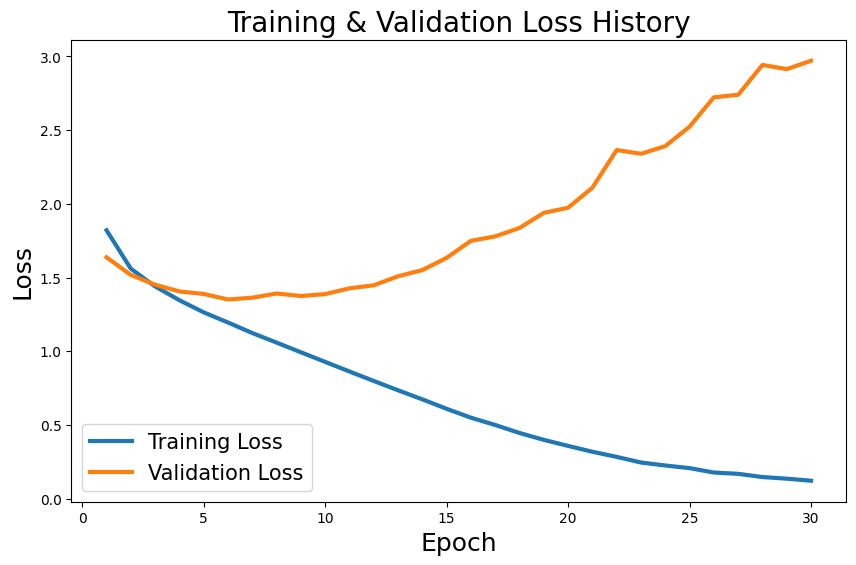

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/lnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

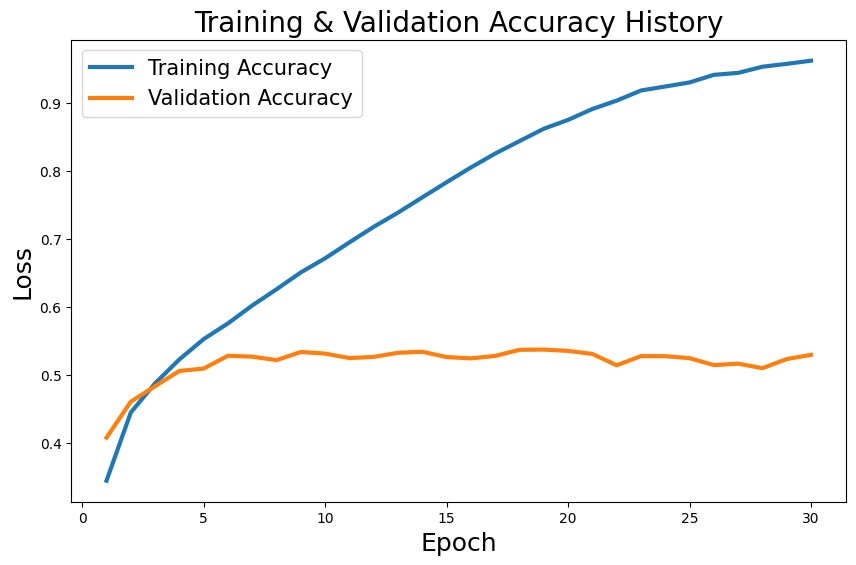

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/lnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [13]:
test_loss, test_accuracy = test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 3.0074, Test Accuracy: 0.5267%


#### Convolutional Neural Network

In [14]:
cnn_model = cnn.CNN(3, num_classes=10)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  6502738


In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='cnn_model')

Epoch 1/30: 100%|██████████| 313/313 [00:00<00:00, 357.95it/s]


Train Loss: 1.7663, Train Accuracy: 0.3523
Valid Loss: 1.5382, Valid Accuracy: 0.4260


Epoch 2/30: 100%|██████████| 313/313 [00:00<00:00, 364.76it/s]


Train Loss: 1.4524, Train Accuracy: 0.4724
Valid Loss: 1.3993, Valid Accuracy: 0.4876


Epoch 3/30: 100%|██████████| 313/313 [00:00<00:00, 331.69it/s]


Train Loss: 1.3192, Train Accuracy: 0.5234
Valid Loss: 1.3135, Valid Accuracy: 0.5176


Epoch 4/30: 100%|██████████| 313/313 [00:00<00:00, 385.51it/s]


Train Loss: 1.2275, Train Accuracy: 0.5602
Valid Loss: 1.2683, Valid Accuracy: 0.5388


Epoch 5/30: 100%|██████████| 313/313 [00:00<00:00, 364.81it/s]


Train Loss: 1.1588, Train Accuracy: 0.5866
Valid Loss: 1.2444, Valid Accuracy: 0.5495


Epoch 6/30: 100%|██████████| 313/313 [00:00<00:00, 370.86it/s]


Train Loss: 1.0991, Train Accuracy: 0.6106
Valid Loss: 1.2055, Valid Accuracy: 0.5640


Epoch 7/30: 100%|██████████| 313/313 [00:01<00:00, 272.73it/s]


Train Loss: 1.0423, Train Accuracy: 0.6292
Valid Loss: 1.1926, Valid Accuracy: 0.5729


Epoch 8/30: 100%|██████████| 313/313 [00:00<00:00, 365.50it/s]


Train Loss: 0.9964, Train Accuracy: 0.6464
Valid Loss: 1.1724, Valid Accuracy: 0.5792


Epoch 9/30: 100%|██████████| 313/313 [00:00<00:00, 376.87it/s]


Train Loss: 0.9544, Train Accuracy: 0.6628
Valid Loss: 1.1775, Valid Accuracy: 0.5799


Epoch 10/30: 100%|██████████| 313/313 [00:00<00:00, 377.76it/s]


Train Loss: 0.9043, Train Accuracy: 0.6794
Valid Loss: 1.1647, Valid Accuracy: 0.5876


Epoch 11/30: 100%|██████████| 313/313 [00:00<00:00, 383.27it/s]


Train Loss: 0.8660, Train Accuracy: 0.6959
Valid Loss: 1.1820, Valid Accuracy: 0.5812


Epoch 12/30: 100%|██████████| 313/313 [00:00<00:00, 374.98it/s]


Train Loss: 0.8256, Train Accuracy: 0.7091
Valid Loss: 1.1735, Valid Accuracy: 0.5890


Epoch 13/30: 100%|██████████| 313/313 [00:00<00:00, 359.35it/s]


Train Loss: 0.7868, Train Accuracy: 0.7253
Valid Loss: 1.1754, Valid Accuracy: 0.5913


Epoch 14/30: 100%|██████████| 313/313 [00:00<00:00, 369.30it/s]


Train Loss: 0.7477, Train Accuracy: 0.7375
Valid Loss: 1.1877, Valid Accuracy: 0.5931


Epoch 15/30: 100%|██████████| 313/313 [00:00<00:00, 364.74it/s]


Train Loss: 0.7107, Train Accuracy: 0.7531
Valid Loss: 1.2087, Valid Accuracy: 0.5932


Epoch 16/30: 100%|██████████| 313/313 [00:00<00:00, 333.26it/s]


Train Loss: 0.6744, Train Accuracy: 0.7663
Valid Loss: 1.2193, Valid Accuracy: 0.5916


Epoch 17/30: 100%|██████████| 313/313 [00:00<00:00, 350.05it/s]


Train Loss: 0.6376, Train Accuracy: 0.7789
Valid Loss: 1.2210, Valid Accuracy: 0.5983


Epoch 18/30: 100%|██████████| 313/313 [00:00<00:00, 381.57it/s]


Train Loss: 0.6063, Train Accuracy: 0.7899
Valid Loss: 1.2532, Valid Accuracy: 0.5945


Epoch 19/30: 100%|██████████| 313/313 [00:00<00:00, 357.67it/s]


Train Loss: 0.5736, Train Accuracy: 0.8032
Valid Loss: 1.2833, Valid Accuracy: 0.5897


Epoch 20/30: 100%|██████████| 313/313 [00:00<00:00, 360.93it/s]


Train Loss: 0.5407, Train Accuracy: 0.8144
Valid Loss: 1.3070, Valid Accuracy: 0.5911


Epoch 21/30: 100%|██████████| 313/313 [00:00<00:00, 366.47it/s]


Train Loss: 0.5118, Train Accuracy: 0.8258
Valid Loss: 1.3395, Valid Accuracy: 0.5875


Epoch 22/30: 100%|██████████| 313/313 [00:00<00:00, 329.30it/s]


Train Loss: 0.4776, Train Accuracy: 0.8363
Valid Loss: 1.3406, Valid Accuracy: 0.5947


Epoch 23/30: 100%|██████████| 313/313 [00:00<00:00, 361.52it/s]


Train Loss: 0.4516, Train Accuracy: 0.8451
Valid Loss: 1.4059, Valid Accuracy: 0.5894


Epoch 24/30: 100%|██████████| 313/313 [00:00<00:00, 360.79it/s]


Train Loss: 0.4193, Train Accuracy: 0.8579
Valid Loss: 1.4216, Valid Accuracy: 0.5881


Epoch 25/30: 100%|██████████| 313/313 [00:00<00:00, 381.01it/s]


Train Loss: 0.3952, Train Accuracy: 0.8680
Valid Loss: 1.4557, Valid Accuracy: 0.5877


Epoch 26/30: 100%|██████████| 313/313 [00:00<00:00, 363.88it/s]


Train Loss: 0.3712, Train Accuracy: 0.8752
Valid Loss: 1.4900, Valid Accuracy: 0.5875


Epoch 27/30: 100%|██████████| 313/313 [00:00<00:00, 369.83it/s]


Train Loss: 0.3434, Train Accuracy: 0.8865
Valid Loss: 1.5204, Valid Accuracy: 0.5909


Epoch 28/30: 100%|██████████| 313/313 [00:00<00:00, 351.37it/s]


Train Loss: 0.3234, Train Accuracy: 0.8937
Valid Loss: 1.5621, Valid Accuracy: 0.5868


Epoch 29/30: 100%|██████████| 313/313 [00:00<00:00, 356.48it/s]


Train Loss: 0.3033, Train Accuracy: 0.9005
Valid Loss: 1.5939, Valid Accuracy: 0.5853


Epoch 30/30: 100%|██████████| 313/313 [00:00<00:00, 386.83it/s]


Train Loss: 0.2861, Train Accuracy: 0.9053
Valid Loss: 1.6138, Valid Accuracy: 0.5871
Total training time: 266.10 seconds.
Best model at epoch 17 with valid loss: 1.2210, valid accuracy: 0.5983


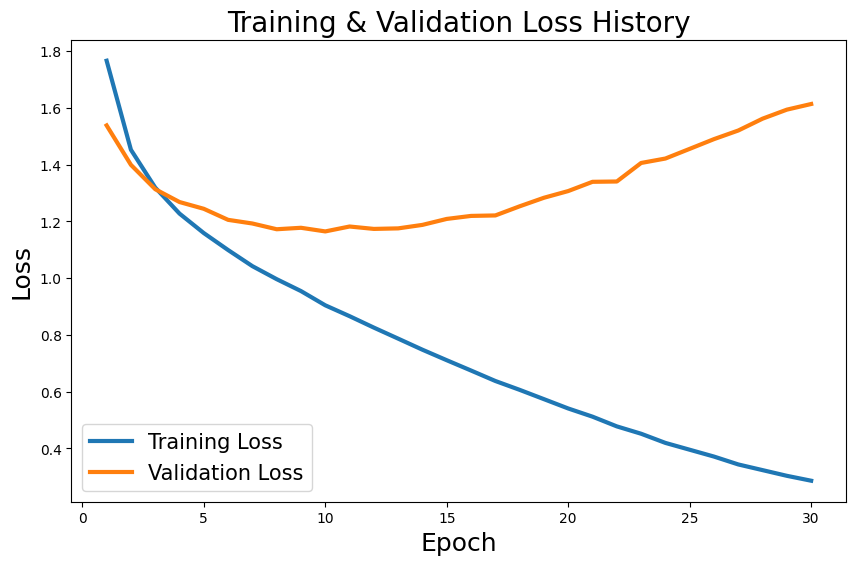

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

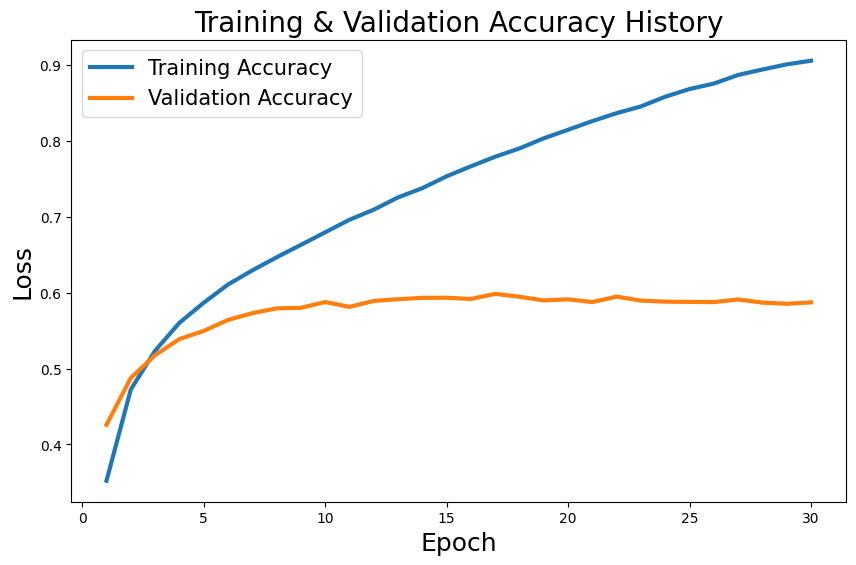

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [18]:
test_loss, test_accuracy = test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 1.6183, Test Accuracy: 0.5951%
